In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from startup import np, pd, plt, sns, os, Path

In [198]:
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import gaussian
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import find_peaks

In [5]:
import pymc as pm
import arviz as az
import bambi as bmb
import statsmodels.formula.api as smf
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

In [6]:
n_devices = 16
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(n_devices)
os.environ['JAX_PLATFORMS'] = 'cpu'  # BlackJAX NUTS sampler seems to have issues with JAX
import jax
import jax.numpy as jnp

In [7]:
f_s = 100
T_x= 1/f_s
T_max = 10
N = T_max * f_s
rw_coords = {'time': np.linspace(0, T_max, N)}
with pm.Model(coords=rw_coords) as rw_model:
    cum_ret = pm.GaussianRandomWalk(
        'cum_ret',
        mu=0,
        sigma=T_max/N,
        init_dist=pm.DiracDelta.dist(c=0), dims='time'
    )
    price = pm.Deterministic('price', pm.math.exp(cum_ret))

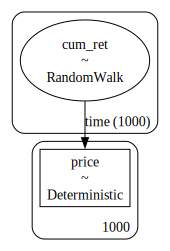

In [8]:
pm.model_to_graphviz(rw_model)

In [9]:
sample_prices = pm.draw(price, 1000).T

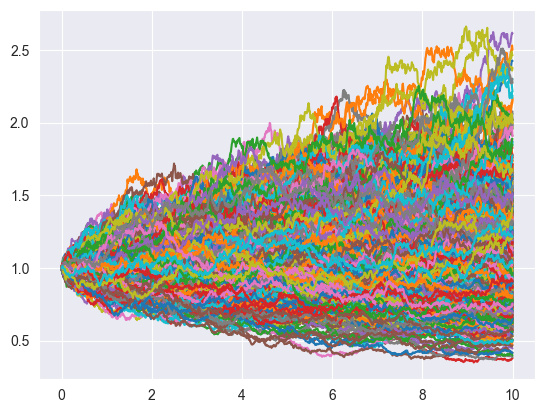

In [10]:
_ = plt.plot(rw_coords['time'], sample_prices)

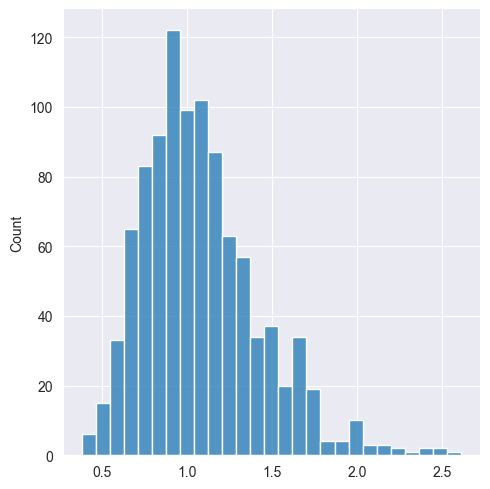

In [11]:
sns.displot(x=sample_prices[-1, :])

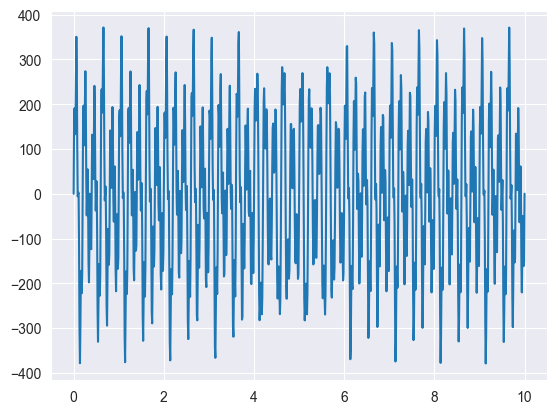

In [241]:
t = np.array(rw_coords['time'])
x = (
        #np.sum(sample_prices, axis=1)
         100*np.sin(2*np.pi*np.where((4 <= t) & (t <= 6), 15, 20)*t)
        + 200*(1 + 0.5*np.sin(2*np.pi*2*t))*np.sin(
    2*np.pi*5*t
)
)
_ = plt.plot(t, x)

In [242]:
X = fft(x)
xf = fftfreq(N, T_x)

In [243]:
X.shape, x.shape

((1000,), (1000,))

[  3.    5.    7.   20.   20.2 -20.2 -20.   -7.   -5.   -3. ]


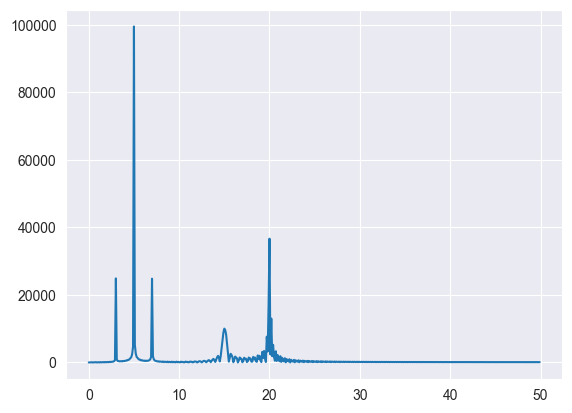

In [244]:
plt.plot(xf[:N//2], np.abs(X)[:N//2])
peaks, properties = find_peaks(np.abs(X), threshold=10000)
print(xf[peaks])

In [282]:
# Spectrogram of sum of prices
g_std = 50  # standard deviation for Gaussian window in samples
w = gaussian(200, std=g_std, sym=True)  # symmetric Gaussian window

200

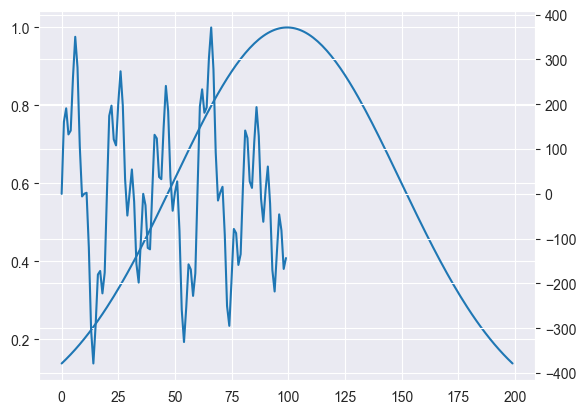

In [283]:
fig, ax = plt.subplots()
_ = ax.plot(w)
ax2 = ax.twinx()
ax2.plot(x[:100])
len(w)

In [284]:
SFT = ShortTimeFFT(w, hop=10, fs=f_s, mfft=200, scale_to='magnitude')
Sx = SFT.stft(x)  # perform the STFT
Sx.shape

(101, 119)

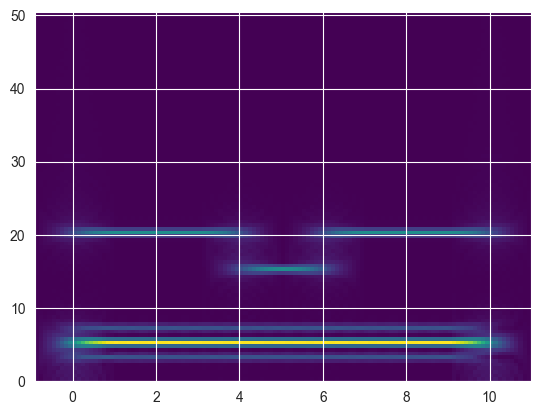

In [285]:
plt.imshow(np.abs(Sx[0:, :]), cmap='viridis', origin='lower', aspect='auto',
                 extent=SFT.extent(N))

Scipy Doc [example](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.ShortTimeFFT.html#scipy.signal.ShortTimeFFT)

In [19]:
def run_doc_example():
    T_x, N = 1 / 20, 1000  # 20 Hz sampling rate for 50 s signal
    t_x = np.arange(N) * T_x  # time indexes for signal
    f_i = 1 * np.arctan((t_x - t_x[N // 2]) / 2) + 5  # varying frequency
    x = np.sin(2*np.pi*np.cumsum(f_i)*T_x) # the signal
    g_std = 8  # standard deviation for Gaussian window in samples
    w = gaussian(50, std=g_std, sym=True)  # symmetric Gaussian window
    SFT = ShortTimeFFT(w, hop=10, fs=1/T_x, mfft=200, scale_to='magnitude')
    Sx = SFT.stft(x)  # perform the STFT
    fig1, ax1 = plt.subplots(figsize=(6., 4.))  # enlarge plot a bit
    t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot
    ax1.set_title(rf"STFT ({SFT.m_num*SFT.T:g}$\,s$ Gaussian window, " +
                  rf"$\sigma_t={g_std*SFT.T}\,$s)")
    ax1.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
                   rf"$\Delta t = {SFT.delta_t:g}\,$s)",
            ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
                   rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
            xlim=(t_lo, t_hi))

    im1 = ax1.imshow(abs(Sx), origin='lower', aspect='auto',
                     extent=SFT.extent(N), cmap='viridis')
    ax1.plot(t_x, f_i, 'r--', alpha=.5, label='$f_i(t)$')
    fig1.colorbar(im1, label="Magnitude $|S_x(t, f)|$")

    # Shade areas where window slices stick out to the side:
    for t0_, t1_ in [(t_lo, SFT.lower_border_end[0] * SFT.T),
                     (SFT.upper_border_begin(N)[0] * SFT.T, t_hi)]:
        ax1.axvspan(t0_, t1_, color='w', linewidth=0, alpha=.2)
    for t_ in [0, N * SFT.T]:  # mark signal borders with vertical line:
        ax1.axvline(t_, color='y', linestyle='--', alpha=0.5)
    ax1.legend()
    fig1.tight_layout()
plt.show()